# Branching

So far, we have only looked at pipelines that operate in a direct sequential manner, one step after the other. However, `edit.pipeline` can do more then that, and can create / manage branches of operations, for example, multiple sources, different operations applied to copys of data, mapping tuples over branches and more.

This notebook seeks to explain how to configure this

In [1]:
import edit.pipeline
import edit.data

To make branches, when setting up the pipeline pass a tuple as a step, with the steps as elements within. 

If this tuple is only one layer deep, as in `(0,1,2)` each step will be treated as a one element branch, i.e. a one step pipeline. However, if it is two deep i.e. `((0,1),(2,3))` each internal tuple is expanded into a pipeline. These rules the repeat to allow branches within branches within branches ....

## Multiple Inputs

A common use for branches is multiple sources of data, i.e. from different datasets or the same dataset just prepared in a different way. 

Simply pass a tuple as the first element of the pipeline

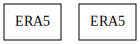

In [2]:
edit.pipeline.Pipeline(
    (edit.data.archive.ERA5.sample(), edit.data.archive.ERA5.sample()),
)

## Pipelines within branches

Using the above example, say we want to apply a step to only one branch.

We do this by nesting another tuple with the operation following the index like we would a normal pipeline

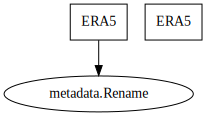

In [3]:
edit.pipeline.Pipeline(
    (
        (edit.data.archive.ERA5.sample(), edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'})), 
    edit.data.archive.ERA5.sample()),
)

## Merge
As part of all data type operations are steps specialised in merging tuples together or splitting an element into a tuple.

These are very useful for working with branches. Simply add them as you would a normal step

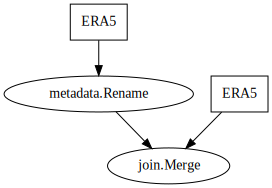

In [4]:
merged_pipeline = edit.pipeline.Pipeline(
    (
        (edit.data.archive.ERA5.sample(), edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'})), 
    edit.data.archive.ERA5.sample()),
    edit.pipeline.operations.xarray.Merge(),
)
merged_pipeline

In [5]:
merged_pipeline['2000-01-01T00']

<xarray.Dataset> Size: 17MB
Dimensions:              (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude            (longitude) float32 6kB -180.0 -179.8 ... 179.5 179.8
  * latitude             (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * time                 (time) datetime64[ns] 8B 2000-01-01
Data variables:
    2_metre_temperature  (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 182, 360), meta=np.ndarray>
    2t                   (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 182, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

## Within Pipeline Branches
Branches at the start are very useful, but they can also be used within a pipeline to take one sample of data and apply more then one sequence of operations to it. For this the data is copied, and then all branches run on a seperate copy.

The sample is then returned as a tuple of the same length as the number of branches, in the same order as the branches are given.

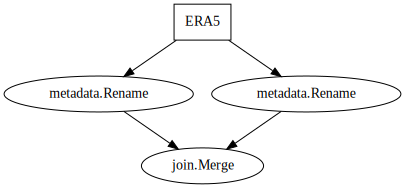

In [6]:
merged_pipeline = edit.pipeline.Pipeline(
    edit.data.archive.ERA5.sample(),
    (
        edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'}), edit.pipeline.operations.xarray.metadata.Rename({'2t':'t2m'}),
    ), 
    edit.pipeline.operations.xarray.Merge(),
)
merged_pipeline

In [7]:
merged_pipeline['2000-01-01T00']

<xarray.Dataset> Size: 17MB
Dimensions:              (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude            (longitude) float32 6kB -180.0 -179.8 ... 179.5 179.8
  * latitude             (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * time                 (time) datetime64[ns] 8B 2000-01-01
Data variables:
    2_metre_temperature  (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 182, 360), meta=np.ndarray>
    t2m                  (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 182, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

### Mapped Branches
In addition to copying the data to be modified multiple different ways, elements of a tuple can be mapped across to the branches instead.

So, given a branch of two, a tuple of size two can be split such that the first element is given to the first branch, and the second to the second and so on.

This uses the exact same syntax as above, but instead include a 'map' literal as the last specified branch. It is then removed and the branch configured for mapping.

The size of the tuple and the branches must match exactly, or else an error will be thrown.

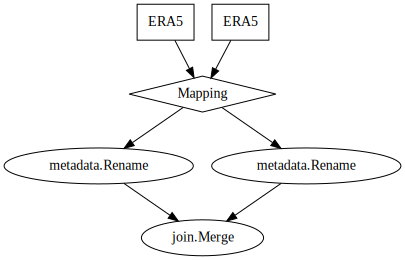

In [8]:
edit.pipeline.Pipeline(
    (edit.data.archive.ERA5.sample(),edit.data.archive.ERA5.sample()),
    (
        edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'}), edit.pipeline.operations.xarray.metadata.Rename({'2t':'t2m'}), 'map'
    ), 
    edit.pipeline.operations.xarray.Merge(),
)

### Empty Branches
If no modifications are to be applied to a certain element of a tuple, a `edit.pipeline.Empty()` can be used to not modify the data but fullfill the length requirements.

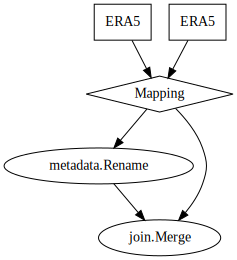

In [9]:
edit.pipeline.Pipeline(
    (edit.data.archive.ERA5.sample(),edit.data.archive.ERA5.sample()),
    (
        edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'}), edit.pipeline.Empty(), 'map'
    ), 
    edit.pipeline.operations.xarray.Merge(),
)

## Full example

With the above knowledge, you should be equipped to build a branching pipeline, but just to make sure, below is an example using `Markers` to print out the data as it follows through. Hopefully it is clear how these steps work together

In [10]:
Step = lambda x: edit.pipeline.Marker(x, print = True) # Fake Step

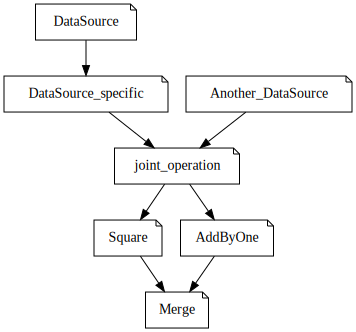

In [11]:
example_pipe = edit.pipeline.Pipeline(
    (
        edit.pipeline.Pipeline(Step('DataSource'), Step('DataSource_specific')), # Data Source with a specific step
        Step('Another_DataSource'), # Lone Data source
    ),
    Step('joint_operation'), # An operation to be applied to the tuple of sources
    (
        Step('Square'), Step('AddByOne'), 'map', # Tuple is then mapped between these two fake operations each recieving a single element
    ),
    Step('Merge'), # A hypothetical merge operation
)
example_pipe

In [12]:
example_pipe.apply(1)

At marker 'DataSource' sample was:
1
At marker 'DataSource_specific' sample was:
1
At marker 'Another_DataSource' sample was:
1
At marker 'joint_operation' sample was:
(1, 1)
At marker 'Square' sample was:
1
At marker 'AddByOne' sample was:
1
At marker 'Merge' sample was:
(1, 1)


(1, 1)